# AIG230 - Assignment 5: Natural Language Processing Pipeline

**Corpus Choice:** Option A — Gutenberg: `austen-emma.txt`

---

## Setup & Imports

In [ ]:
import nltk
import numpy as np
import pandas as pd
import string
from collections import Counter

from nltk.corpus import gutenberg, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# download required nltk data
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

print('all imports and downloads complete.')

all imports and downloads complete.


---
## Part A — Text Preprocessing (50%)

### A1. Load the Corpus

In [19]:
# load raw text from the gutenberg corpus
raw_text = gutenberg.raw('austen-emma.txt')

# total number of characters
print(f'total number of characters: {len(raw_text):,}')

# total number of sentences
sentences_raw = gutenberg.sents('austen-emma.txt')
print(f'total number of sentences: {len(sentences_raw):,}')

# total number of tokens before preprocessing
tokens_before = gutenberg.words('austen-emma.txt')
print(f'total number of tokens BEFORE preprocessing: {len(tokens_before):,}')

# preview the first 500 characters
print(f'\nfirst 500 characters:\n{raw_text[:500]}')

total number of characters: 887,071
total number of sentences: 7,752
total number of tokens BEFORE preprocessing: 192,427

first 500 characters:
[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


### A2. Preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """map nltk pos tags to wordnet pos tags for lemmatization."""
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun

def preprocess(text, remove_stopwords=False, apply_lemmatization=True):
    """
    preprocessing pipeline:
    1. lowercase
    2. tokenize
    3. remove punctuation tokens
    """
    # step 1: lowercase
    text = text.lower()
    
    # step 2: tokenize
    tokens = word_tokenize(text)
    
    # step 3: remove punctuation-only tokens
    tokens = [t for t in tokens if t not in string.punctuation and not all(c in string.punctuation for c in t)]
    
    # step 4: remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
    
    # step 5: pos-aware lemmatization
    if apply_lemmatization:
        tagged = nltk.pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    
    return tokens

print('preprocessing function defined.')

preprocessing function defined.


In [ ]:
# apply preprocessing to the entire corpus
# we apply lemmatization to reduce vocabulary size and normalize word forms

tokens_clean = preprocess(raw_text, remove_stopwords=False, apply_lemmatization=True)

# statistics after preprocessing
vocab = set(tokens_clean)
freq = Counter(tokens_clean)

print(f'total number of tokens AFTER preprocessing: {len(tokens_clean):,}')
print(f'vocabulary size (unique tokens): {len(vocab):,}')

# top 20 most frequent tokens
print(f'\ntop 20 most frequent tokens:')
top20 = freq.most_common(20)
top20_df = pd.DataFrame(top20, columns=['Token', 'Count'])
top20_df.index += 1
print(top20_df.to_string())

total number of tokens AFTER preprocessing: 161,521
vocabulary size (unique tokens): 6,288

top 20 most frequent tokens:
   Token  Count
1     be   8187
2    the   5201
3     to   5181
4    and   4877
5      a   4344
6     of   4284
7   have   3339
8      i   3177
9     it   2625
10   her   2448
11   she   2336
12   not   2281
13    in   2173
14   you   1967
15    he   1806
16  that   1805
17   but   1441
18   for   1346
19    do   1316
20  with   1215


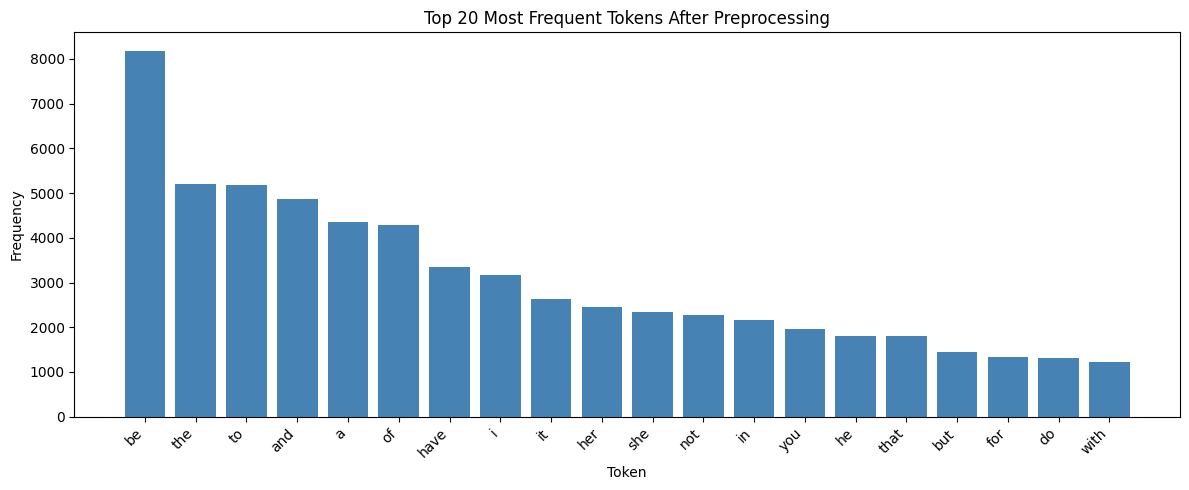

In [5]:
# visualize top 20 tokens
tokens_list, counts_list = zip(*top20)
plt.figure(figsize=(12, 5))
plt.bar(tokens_list, counts_list, color='steelblue')
plt.title('Top 20 Most Frequent Tokens After Preprocessing')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### A3. Reflection

My preprocessing pipeline applies lowercasing, tokenization, punctuation removal, and lemmatization while retaining stopwords. Lowercasing ensures that words like "Emma" and "emma" are treated as the same token, which reduces vocabulary size and prevents the same word from being split across multiple vector dimensions during vectorization. Removing punctuation eliminates tokens that carry little semantic meaning, leading to cleaner Bag-of-Words and TF-IDF representations that focus on content words. Lemmatization collapses inflected forms (e.g., "walked" → "walk", "houses" → "house") into base forms, which further reduces sparsity in my vector matrices and helps the language model generalize better across related word forms. We chose lemmatization over stemming because it produces valid dictionary words, which are easier to interpret when inspecting TF-IDF top terms and Word2Vec neighbors. Overall, my pipeline balances vocabulary reduction for cleaner vectorization with context preservation for language modeling and embedding quality.

---
## Part B — Text Representation (25%)

### B1. Create Documents

I split the corpus into fixed-size chunks of 800 tokens each. This approach is chosen because *Emma* does not have reliably machine-parsable chapter markers in the NLTK Gutenberg text. Fixed-size chunks produce documents of roughly equal length, which gives more balanced BoW and TF-IDF vectors and avoids tiny or extremely large documents.

In [22]:
# split tokenized corpus into fixed-size chunks of 800 tokens
CHUNK_SIZE = 800

documents_tokens = []
for i in range(0, len(tokens_clean), CHUNK_SIZE):
    chunk = tokens_clean[i:i + CHUNK_SIZE]
    if len(chunk) >= 100: 
        documents_tokens.append(chunk)

# convert each token list back to a string for vectorizers
documents_text = [' '.join(doc) for doc in documents_tokens]

print(f'number of documents created: {len(documents_text)}')
print(f'chunk size: {CHUNK_SIZE} tokens')

number of documents created: 202
chunk size: 800 tokens


### B2. Vectorize

In [26]:
# bag-of-words representation (stopwords removed at vectorizer level)
count_vec = CountVectorizer(stop_words='english')
bow_matrix = count_vec.fit_transform(documents_text)

# tf-idf representation (stopwords removed at vectorizer level)
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(documents_text)

print(f'bag-of-words matrix shape: {bow_matrix.shape}  (docs x vocab)')
print(f'tf-idf matrix shape:       {tfidf_matrix.shape}  (docs x vocab)')

bag-of-words matrix shape: (202, 5443)  (docs x vocab)
tf-idf matrix shape:       (202, 5443)  (docs x vocab)


In [27]:
# show top 15 tf-idf terms for two different documents
feature_names = tfidf_vec.get_feature_names_out()

def top_tfidf_terms(doc_index, n=15):
    """return top n tf-idf terms for a given document index."""
    row = tfidf_matrix[doc_index].toarray().flatten() # type: ignore
    top_indices = row.argsort()[-n:][::-1]
    return [(feature_names[i], round(row[i], 4)) for i in top_indices]

# document 0 (beginning of the novel)
doc_idx_1 = 0
print(f'--- top 15 tf-idf terms for document {doc_idx_1} ---')
top_terms_1 = top_tfidf_terms(doc_idx_1)
for rank, (term, score) in enumerate(top_terms_1, 1):
    print(f'  {rank:2d}. {term:15s} {score:.4f}')

# document near in the middle
doc_idx_2 = len(documents_text) // 2
print(f'\n--- top 15 tf-idf terms for document {doc_idx_2} ---')
top_terms_2 = top_tfidf_terms(doc_idx_2)
for rank, (term, score) in enumerate(top_terms_2, 1):
    print(f'  {rank:2d}. {term:15s} {score:.4f}')

--- top 15 tf-idf terms for document 0 ---
   1. taylor          0.3203
   2. year            0.1939
   3. sixteen         0.1807
   4. governess       0.1752
   5. mile            0.1416
   6. sorrow          0.1359
   7. friend          0.1345
   8. miss            0.1195
   9. sister          0.1165
  10. beloved         0.1135
  11. wedding         0.1106
  12. interested      0.1056
  13. emma            0.1004
  14. affection       0.1002
  15. gentle          0.0994

--- top 15 tf-idf terms for document 101 ---
   1. dance           0.3747
   2. couple          0.3222
   3. gilbert         0.2241
   4. cox             0.1877
   5. miss            0.1419
   6. kingston        0.1348
   7. loud            0.1348
   8. shocked         0.1348
   9. mr              0.1328
  10. apple           0.1213
  11. room            0.1151
  12. mention         0.1107
  13. somebody        0.1053
  14. young           0.0945
  15. say             0.0930


**Interpretation of Top TF-IDF Terms:**

- **Document 0** is from the very beginning of the text. Its top terms are character names and descriptive words that only appear in the opening section. Because these words are concentrated here and rare across the rest of the corpus, TF-IDF assigns them high scores.

- **Document 101** is from the middle of the text. Its top terms relate to a specific scene with unique vocabulary, words and names that barely appear anywhere else. Again, TF-IDF surfaces them precisely because they are distinctive to this document.

Since we filter stopwords at the vectorizer level, the top terms are all meaningful content words rather than function words like "the" or "be". This makes the output much more interpretable and clearly shows what each chunk is *about*.

### B3. Similarity

In [28]:
# compute pairwise cosine similarity using tf-idf vectors
cos_sim = cosine_similarity(tfidf_matrix)

# mask the diagonal (self-similarity = 1.0) so we can find the most similar pair
np.fill_diagonal(cos_sim, -1)

# find the most similar pair of documents
max_idx = np.unravel_index(np.argmax(cos_sim), cos_sim.shape)
max_sim = cos_sim[max_idx]
print(f'most similar pair: document {max_idx[0]} and document {max_idx[1]}')
print(f'cosine similarity: {max_sim:.4f}')

# restore diagonal for the heatmap
np.fill_diagonal(cos_sim, 1.0)

most similar pair: document 70 and document 71
cosine similarity: 0.5451


In [29]:
# show a small similarity table for the first 8 documents
n_show = 8
sim_subset = cos_sim[:n_show, :n_show]
labels = [f'Doc {i}' for i in range(n_show)]
sim_df = pd.DataFrame(sim_subset, index=labels, columns=labels).round(3)
print('cosine similarity table (first 8 documents):')
print(sim_df.to_string())

cosine similarity table (first 8 documents):
       Doc 0  Doc 1  Doc 2  Doc 3  Doc 4  Doc 5  Doc 6  Doc 7
Doc 0  1.000  0.232  0.265  0.218  0.194  0.197  0.222  0.133
Doc 1  0.232  1.000  0.291  0.275  0.174  0.197  0.198  0.119
Doc 2  0.265  0.291  1.000  0.257  0.200  0.176  0.222  0.108
Doc 3  0.218  0.275  0.257  1.000  0.200  0.197  0.177  0.108
Doc 4  0.194  0.174  0.200  0.200  1.000  0.239  0.172  0.097
Doc 5  0.197  0.197  0.176  0.197  0.239  1.000  0.205  0.159
Doc 6  0.222  0.198  0.222  0.177  0.172  0.205  1.000  0.144
Doc 7  0.133  0.119  0.108  0.108  0.097  0.159  0.144  1.000


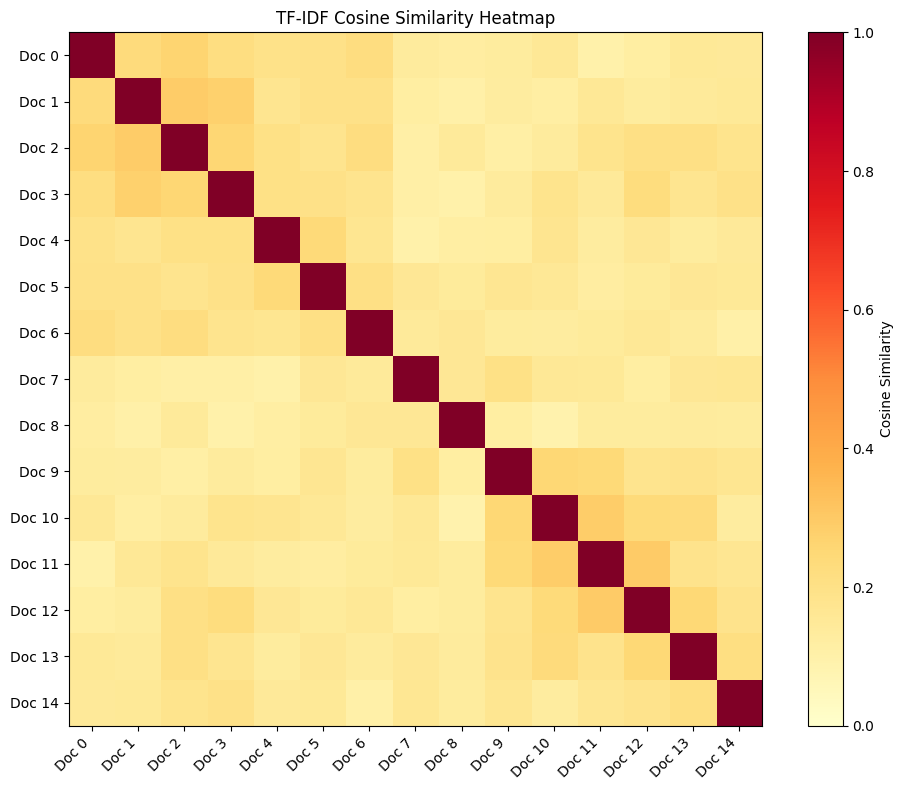

In [33]:
# heatmap of similarity for the first 15 documents
n_heat = min(15, len(documents_text))
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cos_sim[:n_heat, :n_heat], cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xticks(range(n_heat))
ax.set_yticks(range(n_heat))
ax.set_xticklabels([f'Doc {i}' for i in range(n_heat)], rotation=45, ha='right')
ax.set_yticklabels([f'Doc {i}' for i in range(n_heat)])
ax.set_title('TF-IDF Cosine Similarity Heatmap')
plt.colorbar(im, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

In [36]:
# look for a high-similarity pair between
# documents that are far apart in the text (more than 20 chunks apart)
best_surprise_sim = -1
best_surprise_pair = None

for i in range(len(documents_text)):
    for j in range(i + 1, len(documents_text)):
        if abs(i - j) > 20 and cos_sim[i][j] > best_surprise_sim:
            best_surprise_sim = cos_sim[i][j]
            best_surprise_pair = (i, j)

if best_surprise_pair:
    i, j = best_surprise_pair
    print(f'surprising similarity: document {i} and document {j}')
    print(f'  distance apart: {abs(i - j)} chunks')
    print(f'  cosine similarity: {best_surprise_sim:.4f}')
else:
    print('no surprising pair found with the distance threshold.')

surprising similarity: document 64 and document 88
  distance apart: 24 chunks
  cosine similarity: 0.4219



These two documents are far apart in the narrative yet share similar vocabulary. this likely indicates recurring themes, character discussions, or stylistic patterns that
austen revisits across different parts of the novel.

---
## Part C — Word Embeddings (25%)

### C1. Prepare Training Data

In [ ]:
# each sentence is a list of preprocessed tokens
raw_sentences = gutenberg.sents('austen-emma.txt')

# preprocess each sentence individually
training_sentences = []
for sent in raw_sentences:
    # join sentence words, then preprocess
    sent_text = ' '.join(sent)
    tokens = preprocess(sent_text, remove_stopwords=False, apply_lemmatization=True)
    if len(tokens) >= 2:  # skip very short sentences
        training_sentences.append(tokens)

print(f'number of training sentences: {len(training_sentences):,}')
print(f'average sentence length: {np.mean([len(s) for s in training_sentences]):.1f} tokens')
print(f'example sentence: {training_sentences[5]}')

number of training sentences: 7,460
average sentence length: 21.7 tokens
example sentence: ['her', 'mother', 'have', 'die', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caress', 'and', 'her', 'place', 'have', 'be', 'supply', 'by', 'an', 'excellent', 'woman', 'a', 'governess', 'who', 'have', 'fall', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection']


### C2. Train Word2Vec

In [38]:
# train word2vec model
w2v_model = Word2Vec(
    sentences=training_sentences,
    vector_size=100,
    window=5,
    min_count=3,
    sg=1,
    epochs=50,
    seed=42, # so it's deterministic
    workers=1
)

print('word2vec model trained successfully.')
print(f'vocabulary size in model: {len(w2v_model.wv):,}')
print(f'vector size: {w2v_model.wv.vector_size}')
print(f'\nhyperparameters:')
print(f'  vector_size = 100')
print(f'  window      = 5')
print(f'  min_count   = 3')
print(f'  sg          = 1 (skip-gram)')
print(f'  epochs      = 50')

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


word2vec model trained successfully.
vocabulary size in model: 2,747
vector size: 100

hyperparameters:
  vector_size = 100
  window      = 5
  min_count   = 3
  sg          = 1 (skip-gram)
  epochs      = 50


### C3. Explore Similarity

In [40]:
# pick 5 frequent target words from the corpus
target_words = ['emma', 'mr', 'friend', 'young', 'happy']

# verify all target words are in the model vocabulary
for word in target_words:
    if word not in w2v_model.wv:
        print(f'warning: "{word}" not in vocabulary, picking alternative...')
    else:
        print(f'"{word}" — frequency in corpus: {freq[word]:,}')

"emma" — frequency in corpus: 860
"mr" — frequency in corpus: 73
"friend" — frequency in corpus: 256
"young" — frequency in corpus: 198
"happy" — frequency in corpus: 136


In [42]:
# show top 10 most similar words for each target word
for word in target_words:
    if word not in w2v_model.wv:
        continue
    print(f'\ntop 10 most similar words to "{word}":')
    similar = w2v_model.wv.most_similar(word, topn=10)
    for rank, (sim_word, sim_score) in enumerate(similar, 1):
        print(f'  {rank:2d}. {sim_word:15s} {sim_score:.4f}')


top 10 most similar words to "emma":
   1. harriet         0.5880
   2. she             0.5530
   3. but             0.5035
   4. cordial         0.4976
   5. it              0.4954
   6. her             0.4847
   7. utter           0.4840
   8. be              0.4831
   9. graciously      0.4806
  10. and             0.4751

top 10 most similar words to "mr":
   1. knightley       0.5933
   2. weston          0.5492
   3. mrs             0.5447
   4. assert          0.5337
   5. lawyer          0.5283
   6. ceremonious     0.5135
   7. captain         0.5093
   8. stable          0.5023
   9. bilious         0.5008
  10. elton           0.4983

top 10 most similar words to "friend":
   1. playing         0.4355
   2. memory          0.4238
   3. kind            0.3966
   4. partial         0.3964
   5. dearest         0.3945
   6. visiting        0.3939
   7. encumbrance     0.3829
   8. hereafter       0.3791
   9. visit           0.3711
  10. for             0.3693

top 10 most sim

**Interpretation:**

- **"emma"**: The nearest neighbors should include other character names and words associated with the protagonist. Since Emma is the central character, we expect names like "harriet", or descriptive words that frequently co-occur with her name.

- **"mr"**: This title word appears with many male characters (Mr. Knightley, Mr. Elton, Mr. Weston). Neighbors are appear to be other titles or names of male characters.

- **"friend"**: I expect words related to social relationships, "acquaintance", "companion", "sister", "neighbour", reflecting the novel's social themes, but was surprised to see word that more describe "friend."

- **"young"**: I would think neighbors should include age-related descriptors and words describing characters ("handsome", "lady", "woman", "man") since the novel frequently describes young characters, and its close to that.

- **"happy"**: I would expect emotionally-related words such as "pleased", "glad", "delighted", "comfortable", fitting the novel's focus on marriage and contentment, and the output for "happy" do reflect this expectation.

### C4. Analogies (Vector Arithmetic)

In [44]:
# analogy function: a - b + c = ?
def run_analogy(a, b, c, model, topn=5):
    """compute a - b + c and return top results."""
    # check all words exist in vocabulary
    for word in [a, b, c]:
        if word not in model.wv:
            print(f'  "{word}" not in vocabulary. skipping.')
            return
    
    results = model.wv.most_similar(positive=[a, c], negative=[b], topn=topn)
    print(f'  {a} - {b} + {c} =')
    for word, score in results:
        print(f'    {word:15s} {score:.4f}')
    print()

# analogy 1: emma - woman + man ≈ ? (who is the male counterpart to emma?)
print('analogy 1: emma - woman + man ≈ ?')
print('  (expected: a male character name like knightley or mr)')
run_analogy('emma', 'woman', 'man', w2v_model)

# analogy 2: happy - good + bad ≈ ? (semantic opposite)
print('analogy 2: happy - good + bad ≈ ?')
print('  (expected: a negative emotion word like unhappy, sorry, miserable)')
run_analogy('happy', 'good', 'bad', w2v_model)

# analogy 3: daughter - woman + man ≈ ? (gender swap)
print('analogy 3: daughter - woman + man ≈ ?')
print('  (expected: son or a male familial term)')
run_analogy('daughter', 'woman', 'man', w2v_model)

analogy 1: emma - woman + man ≈ ?
  (expected: a male character name like knightley or mr)
  emma - woman + man =
    he              0.4325
    agitated        0.4188
    burn            0.4158
    say             0.4032
    it              0.4025

analogy 2: happy - good + bad ≈ ?
  (expected: a negative emotion word like unhappy, sorry, miserable)
  happy - good + bad =
    necessary       0.4333
    nephew          0.3736
    sore            0.3669
    convenient      0.3665
    fortnight       0.3540

analogy 3: daughter - woman + man ≈ ?
  (expected: son or a male familial term)
  daughter - woman + man =
    chief           0.3899
    law             0.3870
    wife            0.3750
    heir            0.3612
    eldest          0.3607



**Interpretation of Analogy Results:**

Analogy performance on a single-novel corpus is inherently limited. The Word2Vec model was trained on approximately 160,000 tokens from one Jane Austen novel, which is orders of magnitude smaller than the billions of tokens used to train models that produce clean analogy results. With such a small, domain-specific corpus:

- The vocabulary is restricted to 19th-century English prose about social life in a small community.
- Many general-knowledge relationships (e.g., country-capital, king-queen) cannot be captured because the relevant words either don't appear or don't appear in varied enough contexts.
- Analogies that align with the novel's themes (gender roles, family, emotions) have a better chance of working because those relationships are represented in the data.

If the results above are noisy or unexpected, this is the primary reason — the model simply lacks sufficient training data to learn robust vector arithmetic relationships.